<a href="https://colab.research.google.com/github/SaiYaswanth-Ammineni/SaiYaswanth-Ammineni/blob/main/Copy_of_major_project_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp /content/kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d safabouguezzi/german-traffic-sign-detection-benchmark-gtsdb

100% 1.61G/1.61G [01:22<00:00, 16.2MB/s]
100% 1.61G/1.61G [01:22<00:00, 21.0MB/s]


In [ ]:
!unzip /content/german-traffic-sign-detection-benchmark-gtsdb.zip

Archive:  /content/german-traffic-sign-detection-benchmark-gtsdb.zip
  inflating: TestIJCNN2013/TestIJCNN2013Download/00000.ppm  
  inflating: TestIJCNN2013/TestIJCNN2013Download/00001.ppm  
  inflating: TestIJCNN2013/TestIJCNN2013Download/00002.ppm  
  inflating: TestIJCNN2013/TestIJCNN2013Download/00003.ppm  
  inflating: TestIJCNN2013/TestIJCNN2013Download/00004.ppm  
  inflating: TestIJCNN2013/TestIJCNN2013Download/00005.ppm  
  inflating: TestIJCNN2013/TestIJCNN2013Download/00006.ppm  
  inflating: TestIJCNN2013/TestIJCNN2013Download/00007.ppm  
  inflating: TestIJCNN2013/TestIJCNN2013Download/00008.ppm  
  inflating: TestIJCNN2013/TestIJCNN2013Download/00009.ppm  
  inflating: TestIJCNN2013/TestIJCNN2013Download/00010.ppm  
  inflating: TestIJCNN2013/TestIJCNN2013Download/00011.ppm  
  inflating: TestIJCNN2013/TestIJCNN2013Download/00012.ppm  
  inflating: TestIJCNN2013/TestIJCNN2013Download/00013.ppm  
  inflating: TestIJCNN2013/TestIJCNN2013Download/00014.ppm  
  inflating: Tes

In [ ]:
import os
import numpy as np
import pandas as pd
from glob import glob
import cv2
import torch
from torch.utils import data
from PIL import Image
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

In [ ]:
txt = np.genfromtxt('/content/gt.txt',delimiter =';', dtype= None,encoding=None)

#Creating a dictionary with image names as key and annotations as value
dic ={}
for i in range (0,len(txt)):
    #Image name is first element of annotation file
    img_name = txt[i][0]
    # 4 Coordinates
    target = [txt[i][1],txt[i][2],txt[i][3],txt[i][4],txt[i][5]]
    #Last element is the class number
    clas = txt[i][-1]
    #If multiple objects, store coordinates and classes as list of lists
    if(img_name in dic):
        dic[img_name].append(target)
    else:
        dic[img_name] = [target]
print(dic['00001.ppm'])
print("Number of Images: " + str(len(dic)))

[[983, 388, 1024, 432, 40], [386, 494, 442, 552, 38], [973, 335, 1031, 390, 13]]
Number of Images: 506


{11: 39, 40: 17, 38: 115, 13: 119, 39: 10, 4: 70, 9: 67, 21: 10, 2: 111, 12: 101, 1: 84, 25: 34, 30: 29, 23: 31, 27: 6, 35: 30, 15: 18, 33: 31, 28: 22, 18: 53, 36: 18, 26: 23, 37: 2, 34: 24, 0: 7, 24: 6, 14: 49, 20: 24, 29: 6, 6: 33, 10: 167, 8: 135, 5: 69, 16: 11, 19: 3, 17: 75, 3: 35, 7: 69, 41: 13, 31: 2, 22: 22, 42: 15, 32: 5}


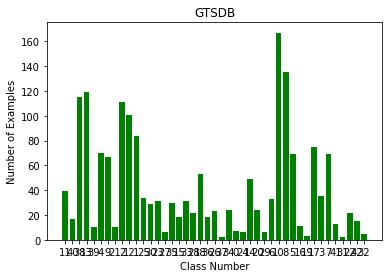

In [ ]:
#Data Distribution

cls_lst = {}

for i in dic:
    for j in dic[i][:]:
        #print(len(dic[i]))
        for k in range(len(dic[i])):
            clss = dic[i][:][k][-1]
            if clss in cls_lst:
                cls_lst[clss] += 1
            else:
                cls_lst[clss] = 1
                
print(cls_lst)

xx = []
yy = []
for i in cls_lst:
    xx.append(str(i))
    yy.append(cls_lst[i])

x_pos = [i for i, _ in enumerate(xx)]

plt.bar(x_pos, yy, color='green')
plt.xlabel("Class Number")
plt.ylabel("Number of Examples")
plt.title("GTSDB")
#plt.figure(figsize=(30,30))
plt.xticks(x_pos, xx)

plt.show()

In [ ]:
#Copy only files that are annotated in the gt.txt to imagesf
import shutil

pt = glob('/content/train/images/*.ppm')

len(pt)
#Copying into new directory
for i in range(len(dic)):
    ofile = r'/content/train/images/{}'.format(list(dic)[i])
    target = r'/content/train/imagesf/{}'.format(list(dic)[i])
    shutil.copyfile(ofile, target)
#Check if len(dic) == number of images in folder
print(len(glob('/content/train/imagesf/*.ppm')))
len(dic)

506


506

In [ ]:
class myDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "imagesf"))))
 
    def __getitem__(self, idx):
        # Load image path
        img_path = os.path.join(self.root, "imagesf", self.imgs[idx])
        #Load image as PIL
        img = Image.open(img_path).convert("RGB")        
        # Get objects in the image
        objects = dic[self.imgs[idx]]
        # Get bounding box coordinates for each object in image
        boxes = []
        labels = []
        for obj in objects:
            #print(idx, obj[-1], self.imgs)
            name = obj[-1]
            labels.append(np.int(name))
            #Get bounding box coordinates
            xmin = np.float(obj[0])
            ymin = np.float(obj[1])
            xmax = np.float(obj[2])
            ymax = np.float(obj[3])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)        
 
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((len(objects),), dtype=torch.int64)
 
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
 
        if self.transforms is not None:
            # Note that target (including bbox) is also transformed\enhanced here, which is different from transforms from torchvision import
            # Https://github.com/pytorch/vision/tree/master/references/detectionOfTransforms.pyThere are examples of target transformations when RandomHorizontalFlip
            img, target = self.transforms(img, target)
 
        return img, target
 
    def __len__(self):
        return len(self.imgs)

In [ ]:
!unzip /content/Traffic-Sign-Detection-with-Faster-R-CNN-using-PyTorch-main.zip

Archive:  /content/Traffic-Sign-Detection-with-Faster-R-CNN-using-PyTorch-main.zip
62301b8aa7a4405d4b7fc79d026d59ef2d7a1e0f
   creating: Traffic-Sign-Detection-with-Faster-R-CNN-using-PyTorch-main/
  inflating: Traffic-Sign-Detection-with-Faster-R-CNN-using-PyTorch-main/Object Detection of Traffic Signs using Faster R-CNN.pdf  
  inflating: Traffic-Sign-Detection-with-Faster-R-CNN-using-PyTorch-main/README.md  
  inflating: Traffic-Sign-Detection-with-Faster-R-CNN-using-PyTorch-main/Traffic Sign Detection with Faster R-CNN.ipynb  
  inflating: Traffic-Sign-Detection-with-Faster-R-CNN-using-PyTorch-main/coco_eval.py  
  inflating: Traffic-Sign-Detection-with-Faster-R-CNN-using-PyTorch-main/coco_utils.py  
  inflating: Traffic-Sign-Detection-with-Faster-R-CNN-using-PyTorch-main/engine.py  
  inflating: Traffic-Sign-Detection-with-Faster-R-CNN-using-PyTorch-main/transforms.py  
  inflating: Traffic-Sign-Detection-with-Faster-R-CNN-using-PyTorch-main/utilss.py  


In [ ]:
import utilss
import transforms as T
from engine import train_one_epoch, evaluate
# utils, transforms, engine were just downloadedUtils.py,transforms.py,engine.py
 
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        # 50% chance of flipping horizontally
        transforms.append(T.RandomHorizontalFlip(0.5))
 
    return T.Compose(transforms)

In [ ]:
from engine import train_one_epoch, evaluate
import utilss
import torch.nn as nn
os.environ['TORCH_HOME'] = '/content'

root = r'/content/train'

# Train on the GPU if available else CPU.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# 44 classes = 43 + background
num_classes = 44
#Send the data to the myDataset class (Apply transformations, Get bbox, labels, objects)
dataset = myDataset(root, get_transform(train=True))
dataset_test = myDataset(root, get_transform(train=False))

# split the dataset in train and test set
# My dataset has 506 images, almost training validation 4:1
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-100])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-100:])

# define training and validation data loaders
#collate_fn returns tuples of images and image annotations for every iteration.
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, # num_workers=4,
    collate_fn=utilss.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=2, shuffle=False, # num_workers=4,
    collate_fn=utilss.collate_fn)

# Define model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, progress=True, num_classes=num_classes, pretrained_backbone=True)
# OR model = get_object_detection_model(num_classes)
#model = torch.load('./train150.pkl')



# Move the model to device
model.to(device)

print("Model loaded")

Model loaded


In [ ]:
from engine import train_one_epoch, evaluate
import utilss
from IPython.display import clear_output
import pickle


# Constructing the optimizer
params = [p for p in model.parameters() if p.requires_grad]

# SGD
optimizer = torch.optim.SGD(params, lr=0.0005,
                            momentum=0.9, weight_decay=0.0005)

# Learning Rate Scheduler
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2)

# Training for no. of Epochs
num_epochs = 10


losses = []
loss_box_reg = []
loss_rpn_box_reg = []
loss_classifier = []
loss_objectness = []

stat0 = []
stat1 = []
stat2 = []
stat3 = []
stat4 = []
stat5 = []
stat6 = []
stat7 = []
stat8 = []
stat9 = []
stat10 = []
stat11 = []


for epoch in range(num_epochs):
    # Engine.py's train_one_epoch function takes both images and targets. to(device)
    # Metrics (metric_logger) was returned by train_one_epoch() in engine.py to get losses
    metrics = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=50)
    losses.append(float(str(metrics.meters['loss']).split(" ")[0]))
    loss_box_reg.append(float(str(metrics.meters['loss_box_reg']).split(" ")[0]))
    loss_rpn_box_reg.append(float(str(metrics.meters['loss_rpn_box_reg']).split(" ")[0]))
    loss_classifier.append(float(str(metrics.meters['loss_classifier']).split(" ")[0]))
    loss_objectness.append(float(str(metrics.meters['loss_objectness']).split(" ")[0]))
    
    # Update the learning rate
    lr_scheduler.step()

    # Evaluate on the test dataset
    # _ gives coco_evaL obj from coco_eval.py from CocoEvaluator()
    _, metric_logger = evaluate(model, data_loader_test, device=device)
    #Stat object is from pycocotools' self.stats in summarize()
    #https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/cocoeval.py
    stat = _.coco_eval['bbox'].stats
    
    #Append all stats
    stat0.append(stat[0])
    stat1.append(stat[1])
    stat2.append(stat[2])
    stat3.append(stat[3])
    stat4.append(stat[4])
    stat5.append(stat[5])
    stat6.append(stat[6])
    stat7.append(stat[7])
    stat8.append(stat[8])
    stat9.append(stat[9])
    stat10.append(stat[10])
    stat11.append(stat[11])
    
    
    print('')
    print('==================================================')
    print('')

print("Done!")

<ipython-input-11-2947022dfadd>:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels.append(np.int(name))
<ipython-input-11-2947022dfadd>:23: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xmin = np.float(obj[0])
<ipyth

Epoch: [0]  [  0/203]  eta: 0:22:50  lr: 0.000003  loss: 4.4757 (4.4757)  loss_classifier: 3.7485 (3.7485)  loss_box_reg: 0.0162 (0.0162)  loss_objectness: 0.6961 (0.6961)  loss_rpn_box_reg: 0.0149 (0.0149)  time: 6.7492  data: 0.0620  max mem: 2582
Epoch: [0]  [ 50/203]  eta: 0:01:53  lr: 0.000127  loss: 1.5576 (3.3002)  loss_classifier: 0.7954 (2.5798)  loss_box_reg: 0.0156 (0.0181)  loss_objectness: 0.6826 (0.6881)  loss_rpn_box_reg: 0.0093 (0.0143)  time: 0.6230  data: 0.0305  max mem: 2845
Epoch: [0]  [100/203]  eta: 0:01:11  lr: 0.000250  loss: 0.2955 (1.9122)  loss_classifier: 0.1227 (1.4045)  loss_box_reg: 0.0347 (0.0254)  loss_objectness: 0.0947 (0.4654)  loss_rpn_box_reg: 0.0066 (0.0170)  time: 0.6583  data: 0.0308  max mem: 2846
Epoch: [0]  [150/203]  eta: 0:00:36  lr: 0.000374  loss: 0.3912 (1.4100)  loss_classifier: 0.2220 (1.0105)  loss_box_reg: 0.1204 (0.0522)  loss_objectness: 0.0468 (0.3316)  loss_rpn_box_reg: 0.0064 (0.0157)  time: 0.6462  data: 0.0313  max mem: 2846


In [ ]:
#Save the model
torch.save(model, r'./train1000.pkl')

torch.save(model.state_dict(), 'train1000.pth')
torch.save({
    'epoch' : epoch,
    "model_state_dict" : model.state_dict(),
    'optimizer_state_dict' : optimizer.state_dict(),
}, 'ckpt1000.pth')

In [ ]:
#Storing losses and stats in pickle format
import pickle

with open('vars1000.pickle', 'wb') as f:
    pickle.dump([losses, loss_box_reg, loss_rpn_box_reg, loss_classifier, loss_objectness, stat0, stat1, stat2, stat3,
 stat4, stat5, stat6, stat7, stat8, stat9, stat10, stat11], f)

In [ ]:
#Load vars pickle file to calc mAP and other statistics. 
with open('vars1000.pickle', 'rb') as f:
    losses, loss_box_reg, loss_rpn_box_reg, loss_classifier, loss_objectness, stat0, stat1, stat2, stat3,stat4, stat5, stat6, stat7, stat8, stat9, stat10, stat11 = pickle.load(f)

In [ ]:
def showbbox(model, img):
    # The img entered is a tensor in the 0-1 range        
    model.eval()
    with torch.no_grad():
        '''
        prediction Like:
        [{'boxes': tensor([[1221.7869,  523.7036, 1272.7373,  575.1018],
        [ 192.8189,  527.5751,  240.7135,  589.8405],
        [ 197.3745,  538.7914,  235.9153,  572.1550],
        [ 195.1216,  533.9565,  238.6585,  578.0548],
        [ 194.0861,  517.0943,  238.0777,  582.4178]], device='cuda:0'), 
        'labels': tensor([7, 7, 7, 8, 5], device='cuda:0'), 
        'scores': tensor([0.9792, 0.9036, 0.2619, 0.2407, 0.0575], device='cuda:0')}]
        '''
        prediction = model([img.to(device)])

    print(prediction)
    b = prediction[0]['boxes']
    #print(b)
    s = prediction[0]['scores']
    #print(s)
    
    #Apply Non-maximum suppression:
    keep = torchvision.ops.nms(b,s,0.1)
    #print(keep)
        
    img = img.permute(1,2,0)  # C,H,W_H,W,C, for drawing
    img = (img * 255).byte().data.cpu()  # * 255, float to 0-255
    img = np.array(img)  # tensor → ndarray
    #Convert np array img to right format.
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #Class number coressponding to Classes
    classes = { 0:' Speed limit (20km/h)' ,
    1:' Speed limit (30km/h)' ,
    2:' Speed limit (50km/h)' ,
    3:' Speed limit (60km/h)' ,
    4:' Speed limit (70km/h)' ,
    5:' Speed limit (80km/h)' ,
    6:' End of speed limit (80km/h)' ,
    7:' Speed limit (100km/h)' ,
    8:' Speed limit (120km/h)' ,
    9:' No passing' ,
    10:' No passing veh over 3.5 tons' ,
    11:' Right-of-way at intersection' ,
    12:' Priority road' ,
    13:' Yield' ,
    14:' Stop' ,
    15:' No vehicles' ,
    16:' Veh > 3.5 tons prohibited' ,
    17:' No entry' ,
    18:' General caution' ,
    19:' Dangerous curve left' ,
    20:' Dangerous curve right' ,
    21:' Double curve' ,
    22:' Bumpy road' ,
    23:' Slippery road' ,
    24:' Road narrows on the right' ,
    25:' Road work' ,
    26:' Traffic signals' ,
    27:' Pedestrians' ,
    28:' Children crossing' ,
    29:' Bicycles crossing' ,
    30:' Beware of ice/snow' ,
    31:' Wild animals crossing' ,
    32:' End speed + passing limits' ,
    33:' Turn right ahead' ,
    34:' Turn left ahead' ,
    35:' Ahead only' ,
    36:' Go straight or right' ,
    37:' Go straight or left' ,
    38:' Keep right' ,
    39:' Keep left' ,
    40:' Roundabout mandatory' ,
    41:' End of no passing' ,
    42:' End no passing veh > 3.5 tons'  }
    
    
    for k in range(len(keep)):
        xmin = round(prediction[0]['boxes'][k][0].item())
        ymin = round(prediction[0]['boxes'][k][1].item())
        xmax = round(prediction[0]['boxes'][k][2].item())
        ymax = round(prediction[0]['boxes'][k][3].item())
        
        label = prediction[0]['labels'][k].item()
        print("Label is: {}\n===\n(Xmin, Ymin, Xmax, Ymax) = ({}, {}, {}, {}) \n===".format(label, xmin, ymin, xmax, ymax))
        
        #color = list(np.random.random(size=3)*256)
        colors = np.random.uniform(0, 255, size=(43, 3))
        
        if label in classes:
            pt1 = (xmin, ymin)
            pt2 = (xmax, ymax)
            print("Class Label: "+ classes[label])
            score = prediction[0]['scores'][k].item()
            print("Score: "+ str(score))
            print("\n===============\n")
            color = list(colors[label])
            cv2.rectangle(img, pt1, pt2, color, thickness=2)
            cv2.putText(img, classes[label]+"-"+str(round(score,2)), (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color,
                        thickness=2)

    plt.figure(figsize=(40,35))
    plt.imshow(img)

print("Function Loaded")

Function Loaded


In [ ]:
#Load saved model
model1 = torch.load(r'./train1000.pkl')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model1.to(device)
print("Model loaded!")

Model loaded!


tensor([[[0.8118, 0.8196, 0.8353,  ..., 0.9529, 0.9843, 1.0000],
         [0.8118, 0.8196, 0.8353,  ..., 0.9529, 0.9843, 1.0000],
         [0.8118, 0.8196, 0.8353,  ..., 0.9529, 0.9843, 1.0000],
         ...,
         [0.1882, 0.1882, 0.1843,  ..., 0.2784, 0.3255, 0.3490],
         [0.1843, 0.1843, 0.1804,  ..., 0.2784, 0.3216, 0.3490],
         [0.1843, 0.1843, 0.1804,  ..., 0.2745, 0.3255, 0.3490]],

        [[0.8000, 0.8078, 0.8235,  ..., 0.8784, 0.9020, 0.9137],
         [0.8000, 0.8078, 0.8235,  ..., 0.8784, 0.9020, 0.9137],
         [0.7961, 0.8039, 0.8235,  ..., 0.8784, 0.9020, 0.9137],
         ...,
         [0.2157, 0.2118, 0.2118,  ..., 0.5216, 0.5647, 0.5843],
         [0.2118, 0.2118, 0.2078,  ..., 0.5216, 0.5608, 0.5843],
         [0.2118, 0.2118, 0.2078,  ..., 0.5216, 0.5608, 0.5843]],

        [[0.6000, 0.6078, 0.6235,  ..., 0.6667, 0.6784, 0.6863],
         [0.6000, 0.6078, 0.6235,  ..., 0.6667, 0.6784, 0.6863],
         [0.5961, 0.6078, 0.6235,  ..., 0.6667, 0.6784, 0.

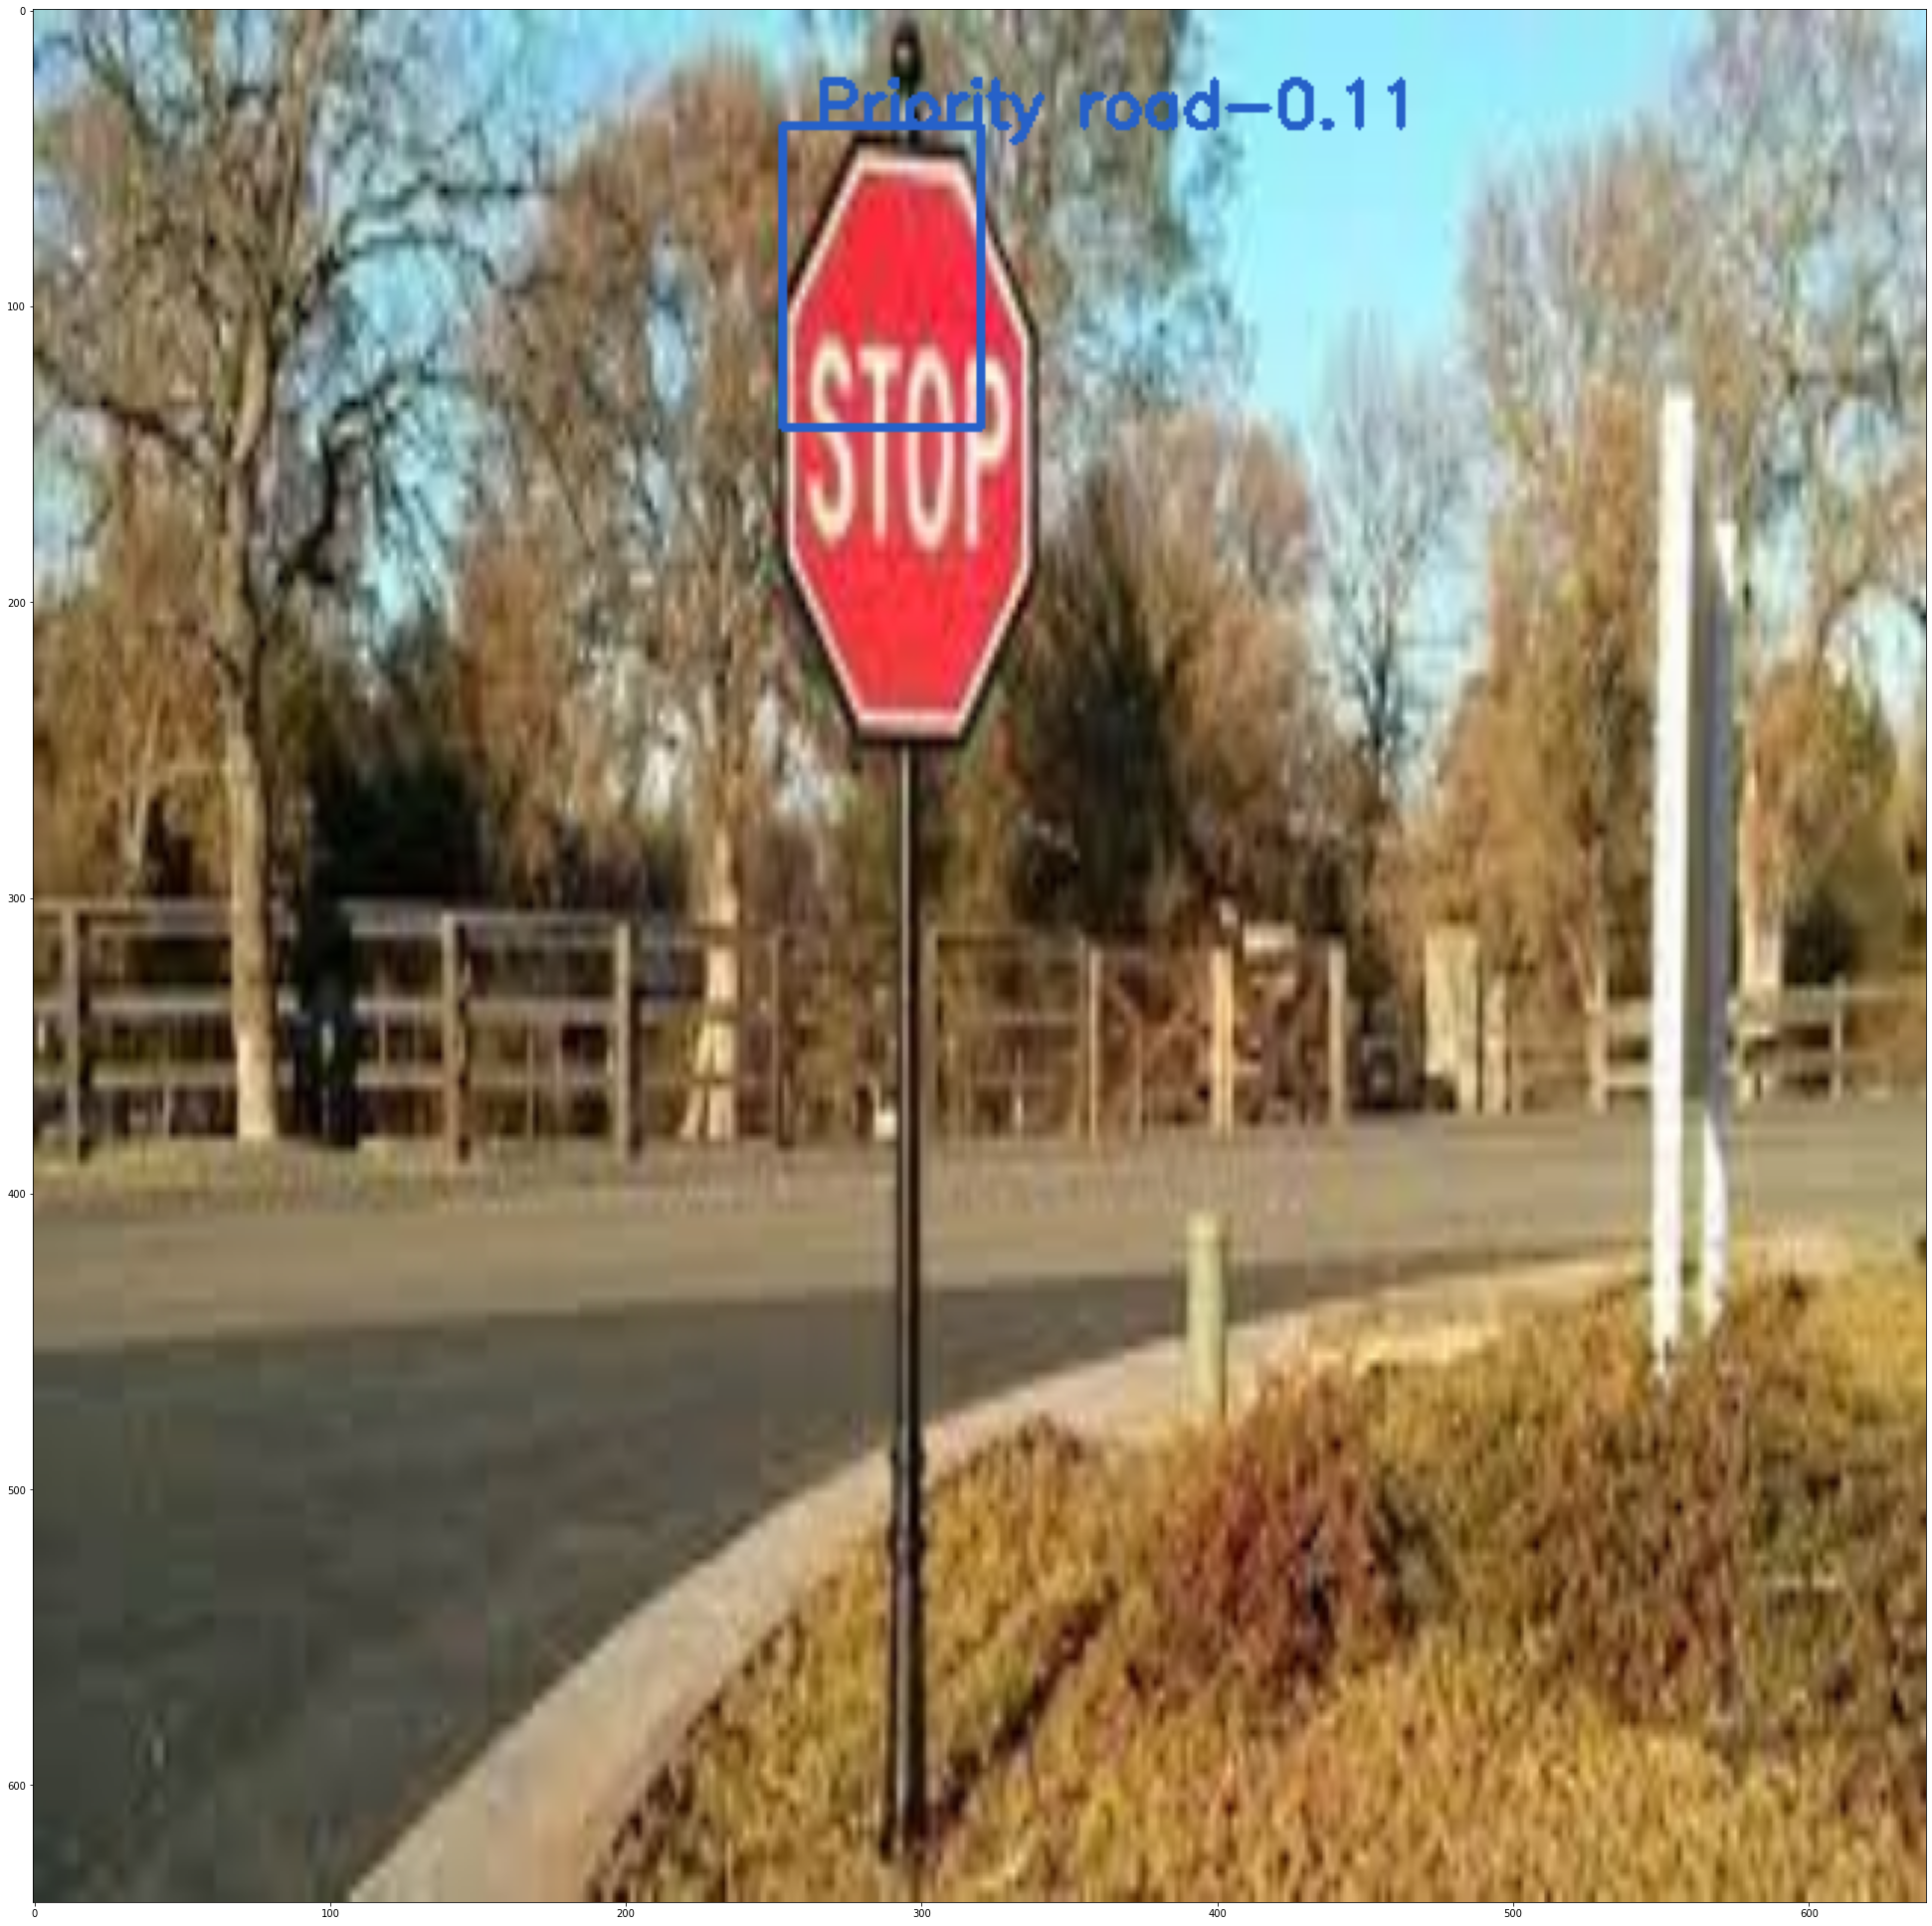

In [30]:
#Test the model:
#Test the model:
import torch
import cv2
import torchvision.transforms as transforms
  
# Read the image
image = cv2.imread('/content/testimageforgds.jpg')
image = cv2.resize(image, (640,640))
# Convert BGR image to RGB image
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  
# Define a transform to convert
# the image to torch tensor
transform = transforms.Compose([
    transforms.ToTensor()
])
  
# Convert the image to Torch tensor
tensor = transform(image)
  
# print the converted image tensor
print(tensor)
showbbox(model, tensor)

In [31]:
!rm -r /content/Traffic-Sign-Detection-with-Faster-R-CNN-using-PyTorch-main

In [32]:
!rm -r /content/german-traffic-sign-detection-benchmark-gtsdb.zip

In [36]:
!zip -r /content/pytorch_faserrcnn.zip /content/*

updating: content/ckpt1000.pth (deflated 7%)
updating: content/coco_eval.py (deflated 74%)
updating: content/coco_utils.py (deflated 72%)
updating: content/engine.py (deflated 66%)
updating: content/gt.txt (deflated 64%)
updating: content/hub/ (stored 0%)
updating: content/hub/checkpoints/ (stored 0%)
updating: content/hub/checkpoints/resnet50-0676ba61.pth (deflated 7%)
updating: content/kaggle.json (deflated 3%)
updating: content/__pycache__/ (stored 0%)
updating: content/__pycache__/engine.cpython-38.pyc (deflated 47%)
updating: content/__pycache__/transforms.cpython-38.pyc (deflated 50%)
updating: content/__pycache__/coco_utils.cpython-38.pyc (deflated 55%)
updating: content/__pycache__/utilss.cpython-38.pyc (deflated 50%)
updating: content/__pycache__/coco_eval.cpython-38.pyc (deflated 53%)
updating: content/sample_data/ (stored 0%)
updating: content/sample_data/anscombe.json (deflated 83%)
updating: content/sample_data/README.md (deflated 42%)
updating: content/sample_data/califor